In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit, orthogonal_mp
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'dataset_corrected/'
x1_train = pd.read_csv(path+'c_data_x1_train.csv')
x2_train = pd.read_csv(path+'c_data_x2_train.csv')
y_train = pd.read_csv(path+'c_data_f1_train.csv')
y_test = pd.read_csv(path+'c_data_f1_test.csv')
x1_test = pd.read_csv(path+'c_data_x1_test.csv')
x2_test = pd.read_csv(path+'c_data_x2_test.csv')

v1_train = pd.read_csv(path+'c_vel_x1_train.csv')
v1_test = pd.read_csv(path+'c_vel_x1_test.csv')
v2_train = pd.read_csv(path+'c_vel_x2_train.csv')
v2_test = pd.read_csv(path+'c_vel_x2_test.csv')

X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train,v1_train,v2_train),axis=1),columns = ['p1','p2','v1','v2'])
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test,v1_test,v2_test),axis=1),columns = ['p1','p2','v1','v2'])
#y_train, y_test = np.array(y_train),np.array(y_test)
X_train.head()

,p1,p2,v1,v2
0,-0.0000,-0.0000,0.0000,0.0000
1,-0.0159,-0.0000,-0.0159,0.0000
2,-0.0159,0.0171,0.0000,0.0171
3,-0.0159,0.0171,0.0000,0.0000
4,-0.0000,0.0329,0.0159,0.0158


In [5]:
x_train = np.array(X_train)
y_train = np.array(y_train)
x_test = np.array(X_test)
y_test = np.array(y_test)

In [6]:
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x_train,y_train)
t2 = datetime.now()

Learning rate set to 0.086822
0:	learn: 0.9233739	total: 9.17ms	remaining: 9.16s
1:	learn: 0.8469976	total: 14.6ms	remaining: 7.29s
2:	learn: 0.7778012	total: 19.6ms	remaining: 6.53s
3:	learn: 0.7144685	total: 24.3ms	remaining: 6.06s
4:	learn: 0.6568190	total: 29ms	remaining: 5.78s
5:	learn: 0.6039335	total: 37.3ms	remaining: 6.19s
6:	learn: 0.5553716	total: 42.4ms	remaining: 6.01s
7:	learn: 0.5107969	total: 47.8ms	remaining: 5.92s
8:	learn: 0.4712609	total: 53.1ms	remaining: 5.84s
9:	learn: 0.4344494	total: 58.1ms	remaining: 5.75s
10:	learn: 0.4004205	total: 63.1ms	remaining: 5.68s
11:	learn: 0.3697927	total: 68.3ms	remaining: 5.62s
12:	learn: 0.3413018	total: 73.4ms	remaining: 5.58s
13:	learn: 0.3152503	total: 78.6ms	remaining: 5.53s
14:	learn: 0.2914985	total: 83.8ms	remaining: 5.5s
15:	learn: 0.2696957	total: 88.9ms	remaining: 5.47s
16:	learn: 0.2502658	total: 94.2ms	remaining: 5.45s
17:	learn: 0.2319850	total: 99.8ms	remaining: 5.44s
18:	learn: 0.2156858	total: 106ms	remaining: 5.

In [7]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Cat Boosting: 0:00:05.586231
Root mean square error of Cat Boost Model:  0.04669560582806921


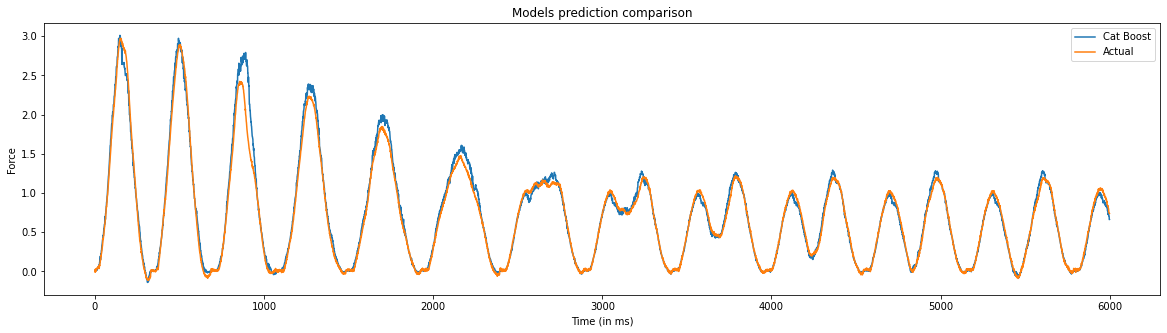

In [8]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()

In [9]:
from scipy import *
from scipy.linalg import norm, pinv
import math

from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

# RBF MODEL with k = 100
rbf = RBF(4, 100, 1)
t1 = datetime.now()
rbf.train(x_train, y_train)
t2 = datetime.now()
    
print('\n\nTime taken by RBF Model: ',t2-t1)
y1_pred = rbf.test(x_test)
y2 = y1_pred
print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))



Time taken by RBF Model:  0:01:31.315104
Root mean square error of RBF Model:  0.04609425156902895


Minimum Error = [2.1459509e-07]
Maximum Error = [0.70796462]
Median Value of Error = [0.02113095]


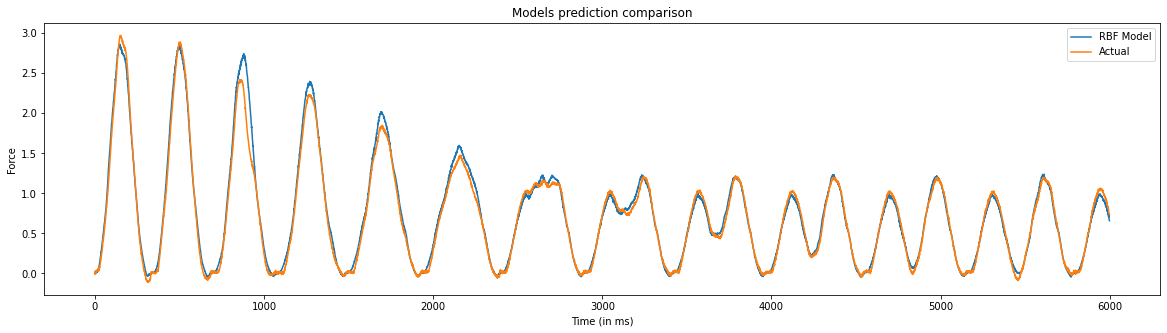

In [10]:
error5 = []
for i in range(len(y_test)):
    error5.append(abs(y1_pred[i]-y_test[i]))
print('Minimum Error =',min(error5))
print('Maximum Error =',max(error5))
error6 = sorted(error5)
print('Median Value of Error =',error6[len(error5)//2])
    
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.show()

Time taken by Random Forest 0:00:34.243517
Root Mean Squared error of Random Forest 0.06636414876216996
Minimum Error = [1.e-06]
Maximum Error = [0.897464]
Median Value of Error = [0.024383]


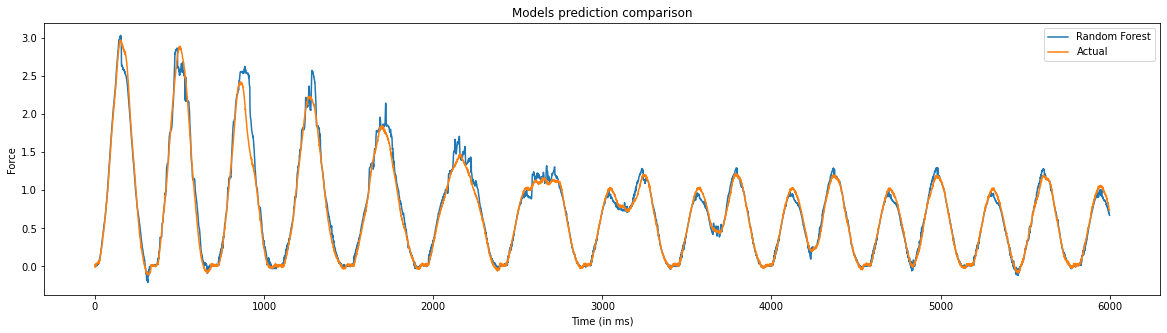

In [11]:
if __name__ == '__main__':
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test[i]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()



Time taken by SVR Model:  0:00:38.047769
Root mean square error of SVR Model:  0.052087724964404
Minimum Error = [3.3897839e-09]
Maximum Error = [0.69020217]
Median Value of Error = [0.03183356]


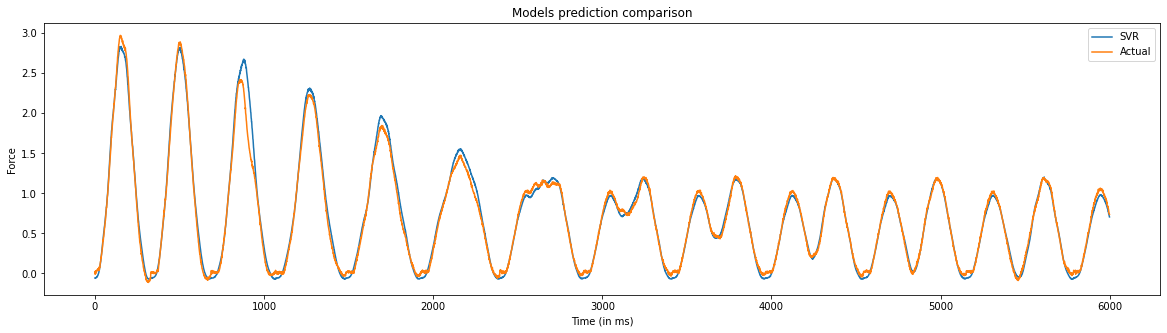

In [12]:
# SVR MODEL
if __name__ == '__main__':
    t1 = datetime.now()
    clf = SVR()
    clf.fit(x_train,y_train)
    t2 = datetime.now()

    print('\n\nTime taken by SVR Model: ',t2-t1)
    y1_pred = clf.predict(x_test)
    y4 = y1_pred
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error7 = []
    for i in range(len(y_test)):
        error7.append(abs(y1_pred[i]-y_test[i]))
    print('Minimum Error =',min(error7))
    print('Maximum Error =',max(error7))
    error8 = sorted(error7)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y4[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()